<a href="https://colab.research.google.com/github/rawat-nitin/ColabGoogleStuff/blob/main/ML_Assignement_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This command intended to aid in the management and monitoring of NVIDIA GPU devices
!nvidia-smi


Wed Dec  8 08:57:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import glob   #The glob module finds all the pathnames matching a specified pattern.
import os     #provides functions for interacting with the operating system.
import shutil   #The shutil module offers a number of high-level operations on files and collections of files.

import matplotlib.pyplot as plt   #collection of command style functions that make matplotlib work like MATLAB.
import numpy as np      # general-purpose array-processing package.
import tensorflow as tf   #an Open-Source library for deep learning and machine learning.

from PIL import Image     #Python Imaging Library (PIL), To load the image.
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping     #early stopping of training via a callback.
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator     #lets you augment your images in real-time while your model is still training!

In [3]:
#Dowloading the Subset for animals {3561}'images
URL = "https://owncloud.cesnet.cz/index.php/s/QnqzgqrGTRknStH/download"
zip_file = tf.keras.utils.get_file(
    origin=URL,
    fname="animals.zip",
    extract=True
)

2707382272/2707367819 [==============================] - 116s 0us/step


In [4]:
base_dir = os.path.join(os.path.dirname(zip_file), "animals")  #the absolute path of the directory where the file resides.
train_dir = os.path.join(base_dir, "train")

classes = ["dolphin", "elephant", "giraffe", "lion", "tiger"]  # These are the classes {categories} 

In [5]:
if not os.path.exists(train_dir):
    # divide images to training and validation sets (run only once)
    for cl in classes:
        img_path = os.path.join(base_dir, cl)
        images = glob.glob(img_path + "/*.jpg")
        print(f"{cl}: {len(images)} images")
        train, val = images[:round(len(images) * 0.8)], images[round(len(images) * 0.8):]

        for t in train:
            if not os.path.exists(os.path.join(base_dir, "train", cl)):
                os.makedirs(os.path.join(base_dir, "train", cl))
            shutil.move(t, os.path.join(base_dir, "train", cl))

        for v in val:
            if not os.path.exists(os.path.join(base_dir, "val", cl)):
                os.makedirs(os.path.join(base_dir, "val", cl))
            shutil.move(v, os.path.join(base_dir, "val", cl))

dolphin: 693 images
elephant: 805 images
giraffe: 644 images
lion: 683 images
tiger: 736 images


In [6]:
!ls /root/.keras/datasets/ -l     #listing the files


total 2643924
drwxr-xr-x 9 root root       4096 Dec  8 09:00 animals
-rw-r--r-- 1 root root 2707367819 Dec  8 08:59 animals.zip


In [7]:
total_train = 0
for cl in classes:                                            #routine for getting total number of train images
    sub_dir = os.path.join(train_dir, cl)
    train_images = glob.glob(sub_dir + "/*.jpg")
    total_train += len(train_images)

validation_dir = os.path.join(base_dir, "val")
total_validation = 0
for cl in classes:                                             #routine for getting total number of validation images
    sub_dir = os.path.join(validation_dir, cl)
    validation_images = glob.glob(sub_dir + "/*.jpg")
    total_validation += len(validation_images)

print("Total train images:", total_train)
print("Total validation images:", total_validation)

Total train images: 2848
Total validation images: 713


In [8]:
def plot_images(images_arr):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

Found 2848 images belonging to 5 classes.


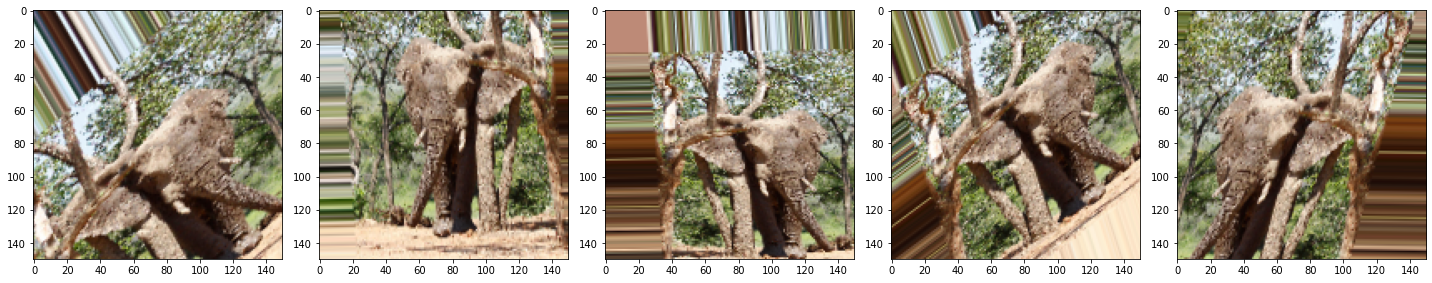

Found 713 images belonging to 5 classes.


In [9]:
BATCH_SIZE = 100
IMG_SHAPE = 150

train_image_generator = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"  # {"constant", "nearest", "reflect", or "wrap"}
)
train_data_gen = train_image_generator.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_SHAPE, IMG_SHAPE),  # (150,150)
    class_mode="sparse"  # {"categorical", "binary", "sparse", "input", or None}
)

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plot_images(augmented_images)

validation_image_generator = ImageDataGenerator(rescale=1. / 255)
val_data_gen = validation_image_generator.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=validation_dir,
    shuffle=False,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    class_mode="sparse"
)

In [10]:
early_stopping = EarlyStopping(monitor="val_loss", min_delta=0, patience=10, verbose=1)
# monitor: quantity to be monitored.
# min_delta: minimum change in the monitored quantity
#     to qualify as an improvement, i.e. an absolute
#     change of less than min_delta, will count as no
#     improvement.
# patience: number of epochs with no improvement
#     after which training will be stopped.

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, verbose=1)
# monitor: quantity to be monitored.
# factor: factor by which the learning rate will
#     be reduced. new_lr = lr * factor
# patience: number of epochs with no improvement
#     after which learning rate will be reduced.

In [19]:
model = tf.keras.models.Sequential([
    Conv2D(16, (3, 3), padding="same", activation=tf.nn.selu, input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
    MaxPooling2D(2, 2),

    Conv2D(32, (3, 3), padding="same", activation=tf.nn.tanh),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), padding="same", activation=tf.nn.relu),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), padding="same", activation=tf.nn.relu),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.2),
    Dense(128, activation=tf.nn.relu,bias_initializer="zeros", bias_regularizer=None),

    Dropout(0.2),
    Dense(5, activation=tf.nn.softmax,bias_initializer="zeros", bias_regularizer=None)
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Summary of the network layers and its parameters
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 75, 75, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 37, 37, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 18, 18, 64)      

In [20]:
EPOCHS = 25
history = model.fit(
    x=train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_validation / float(BATCH_SIZE))),
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/25
29/29 [==============================] - 317s 11s/step - loss: 1.3462 - accuracy: 0.4059 - val_loss: 1.1984 - val_accuracy: 0.4993 - lr: 0.0010
Epoch 2/25
29/29 [==============================] - 302s 11s/step - loss: 1.1850 - accuracy: 0.4853 - val_loss: 1.1648 - val_accuracy: 0.4923 - lr: 0.0010
Epoch 3/25
29/29 [==============================] - 299s 10s/step - loss: 1.1115 - accuracy: 0.5288 - val_loss: 1.1838 - val_accuracy: 0.5203 - lr: 0.0010
Epoch 4/25
29/29 [==============================] - 300s 10s/step - loss: 1.1388 - accuracy: 0.5197 - val_loss: 1.0836 - val_accuracy: 0.5610 - lr: 0.0010
Epoch 5/25
29/29 [==============================] - 300s 10s/step - loss: 1.0616 - accuracy: 0.5600 - val_loss: 1.0088 - val_accuracy: 0.5877 - lr: 0.0010
Epoch 6/25
29/29 [==============================] - 307s 11s/step - loss: 1.0315 - accuracy: 0.5867 - val_loss: 1.0022 - val_accuracy: 0.6045 - lr: 0.0010
Epoch 7/25
29/29 [==============================] - 299s 10s/step - lo

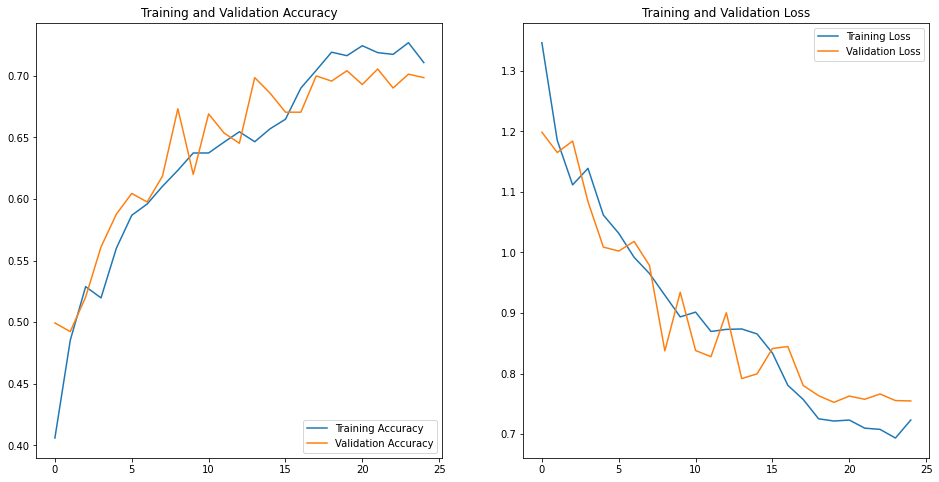

In [22]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(len(history.epoch))

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [30]:
def preprocess_image(img):
    img = Image.open(img)
    # display(img)

    new_size = (IMG_SHAPE, IMG_SHAPE)
    img = img.resize(new_size)
    display(img)

    img_array = np.array(img)
    # print(img_array.shape)
    img_array = img_array.astype(np.float)
    img_array /= 255
    img_array = img_array.reshape((1, IMG_SHAPE, IMG_SHAPE, 3))  # 3 -> color RGB image
    # print(img_array.shape)
    return img_array


def predict_image(img_array):
    prediction = model.predict(img_array)
    print(prediction)
    return prediction

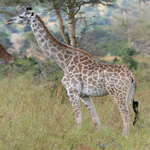

[[0.00114951 0.08153092 0.6300001  0.086284   0.20103544]]
['dolphin', 'elephant', 'giraffe', 'lion', 'tiger']


In [32]:
giraffe_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/9/9e/Giraffe_Mikumi_National_Park.jpg/1200px-Giraffe_Mikumi_National_Park.jpg"
giraffe = tf.keras.utils.get_file("girraffe.jpg", origin=giraffe_url)
predict_image(preprocess_image(giraffe))
print(classes)